https://alexandervandekleut.github.io/deep-q-learning/

In [1]:
!pip install gym -U

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
pip install gym[classic_control]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import numpy as np
import tensorflow as tf
import gym
import matplotlib.pyplot as plt
from tqdm.notebook import trange
from collections import deque
import random

In [4]:
class ReplayBuffer:
    def __init__(self, size=1000000):
        self.memory = deque(maxlen=size)
        
    def remember(self, s_t, a_t, r_t, s_t_next, trunc, d_t):
        self.memory.append((s_t, a_t, r_t, s_t_next, trunc, d_t))
        
    def sample(self, num=32):
        num = min(num, len(self.memory))
        return random.sample(self.memory, num)

In [5]:
class Agent:
    def __init__(self, state_shape, num_actions, num_envs, alpha=0.001, gamma=0.95, epsilon_i=1.0, epsilon_f=0.01, n_epsilon=0.1, hidden_sizes = []):
        self.epsilon_i = epsilon_i
        self.epsilon_f = epsilon_f
        self.n_epsilon = n_epsilon
        self.epsilon = epsilon_i
        self.discount_factor = gamma
        self.learning_rate = alpha

        self.num_actions = num_actions
        self.state_shape = state_shape
        self.num_envs = num_envs

        self.Q = self.create_model()
        
        # target network
        self.Q_ = self.create_model()

        self.synchronize()

    def create_model(self):
        init = tf.keras.initializers.HeUniform()
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.Dense(24, input_shape=self.state_shape, activation='relu', kernel_initializer=init))
        model.add(tf.keras.layers.Dense(12, activation='relu', kernel_initializer=init))
        model.add(tf.keras.layers.Dense(self.num_actions, activation='linear', kernel_initializer=init))
        model.compile(loss=tf.keras.losses.Huber(), optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate), metrics=['mae'])

        return model
    
    def synchronize(self):
        self.Q_.set_weights(self.Q.get_weights())

    def act(self, s_t):
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.num_actions, size=self.num_envs)

        preds = self.Q.predict(np.array([s_t]), verbose=0)
        # print(preds.shape)
        return np.argmax(preds[0], axis=1)
    
    def decay_epsilon(self, n):
        self.epsilon = max(
            self.epsilon_f, 
            self.epsilon_i - (n/self.n_epsilon)*(self.epsilon_i - self.epsilon_f))

    def update(self, batches):
        # Batches is a list of batch
        # One batch contains 6 arrays (one for all states, one for all actions etc...) 
        # of shape env_num, n possibiles (action, obs, etc...)
        X = []
        y = []

        actual_states = np.array([s[0] for s in batches])
        actual_preds = self.Q.predict(actual_states, verbose=0)
        next_states = np.array([s[3] for s in batches])
        target_preds = self.Q_.predict(next_states, verbose=0)

        for x, (states, actions, rewards, next_states, truncs, dones) in enumerate(batches):

          for i in range(len(states)):
            
            if (not dones[i]) and (not truncs[i]):
                max_future_q = rewards[i] + self.discount_factor * np.max(target_preds[x][i])
            else:
                max_future_q = rewards[i]

            act = actions[i]
            current_qs = actual_preds[x][i]
            current_qs[act] = (1 - self.learning_rate) * current_qs[act] + self.learning_rate * max_future_q

            y.append(current_qs)
          
          X.extend(states)
        
        self.Q.fit(np.array([X]), np.array([y]), batch_size=32, verbose=0, shuffle=True)
            

In [6]:
def train(env_name, T=20000, num_envs=32, batch_size=32, sync_every=100, hidden_sizes=[24, 24], alpha=0.001, gamma=0.95):
    env = gym.vector.make(env_name, asynchronous=False, num_envs=num_envs)
    state_shape = env.observation_space.shape
    num_actions = env.single_action_space.n
    agent = Agent(state_shape, num_actions, num_envs, alpha=alpha, hidden_sizes=hidden_sizes, gamma=gamma)
    rewards = []
    buffer = ReplayBuffer()
    episode_rewards = 0
    state, info = env.reset()
    for t in trange(T):
        if t%sync_every == 0:
            agent.synchronize()
        
        action = agent.act(state)
        state_next, reward, done, trunc, info = env.step(action)
        buffer.remember(state, action, reward, state_next, trunc, done)
        state = state_next

        agent.update(buffer.sample(batch_size))
        agent.decay_epsilon(t/T)
        episode_rewards += reward

        # https://www.gymlibrary.dev/content/vectorising/
        for i in range(num_envs):
            if done[i] or trunc[i]:
                rewards.append(episode_rewards[i])
                episode_rewards[i] = 0
                # state[i] = env[i].reset()
            
    # plot(pd.DataFrame(rewards), window=10)
    plt.plot(rewards)
    return agent

  0%|          | 0/2000 [00:00<?, ?it/s]

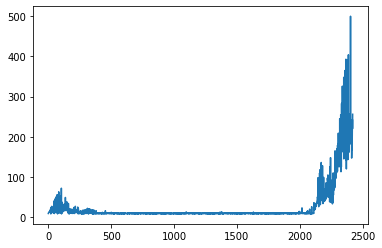

In [7]:
agent = train("CartPole-v1", T=2000, num_envs=32, batch_size=32)

* Batch = 1
* nb_env = 32
* T = 20 000

* Time to train : 4 min 37 sec
* Reach 200 by 2000 steps